### LASSO parameter range experiments

We want to see whether smaller models (i.e. models with fewer nonzero features) tend to generalize to new cancer types better than larger ones; this script compares/visualizes those results.

In [1]:
import os
import itertools as it

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import pearsonr
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
ll_results_dir = os.path.join(
    cfg.repo_root, '01_stratified_classification', 'results', 'optimizer_compare_ll', 'gene'
)

sgd_results_dir = os.path.join(
    cfg.repo_root, '01_stratified_classification', 'results', 'optimizer_compare_sgd', 'gene'
)

plot_gene = 'RB1'
metric = 'aupr'

### Get coefficient information for each lasso penalty

In [3]:
ll_nz_coefs_df = []

# get coefficient info for training dataset specified above
for coef_info in au.generate_nonzero_coefficients_lasso_range(ll_results_dir, gene=plot_gene):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        ll_nz_coefs_df.append(
            [gene, cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
ll_nz_coefs_df = pd.DataFrame(
    ll_nz_coefs_df,
    columns=['gene', 'signal', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
ll_nz_coefs_df.lasso_param = ll_nz_coefs_df.lasso_param.astype(float)
ll_nz_coefs_df = ll_nz_coefs_df[ll_nz_coefs_df.gene == plot_gene].copy()
ll_nz_coefs_df.head()

,gene,signal,lasso_param,seed,fold,nz_coefs
0,RB1,signal,10.00,42,0,3105
1,RB1,signal,10.00,42,1,3167
2,RB1,signal,10.00,42,2,3217
3,RB1,signal,10.00,42,3,3067
4,RB1,signal,0.05,1,0,310


In [4]:
sgd_nz_coefs_df = []

# get coefficient info for training dataset specified above
for coef_info in au.generate_nonzero_coefficients_lasso_range(sgd_results_dir, gene=plot_gene):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        sgd_nz_coefs_df.append(
            [gene, cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
sgd_nz_coefs_df = pd.DataFrame(
    sgd_nz_coefs_df,
    columns=['gene', 'signal', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
sgd_nz_coefs_df.lasso_param = sgd_nz_coefs_df.lasso_param.astype(float)
sgd_nz_coefs_df = sgd_nz_coefs_df[sgd_nz_coefs_df.gene == plot_gene].copy()
sgd_nz_coefs_df.head()

,gene,signal,lasso_param,seed,fold,nz_coefs
0,RB1,signal,0.000001,1,0,15368
1,RB1,signal,0.000001,1,1,15367
2,RB1,signal,0.000001,1,2,15371
3,RB1,signal,0.000001,1,3,15374
4,RB1,signal,10.000000,42,0,0


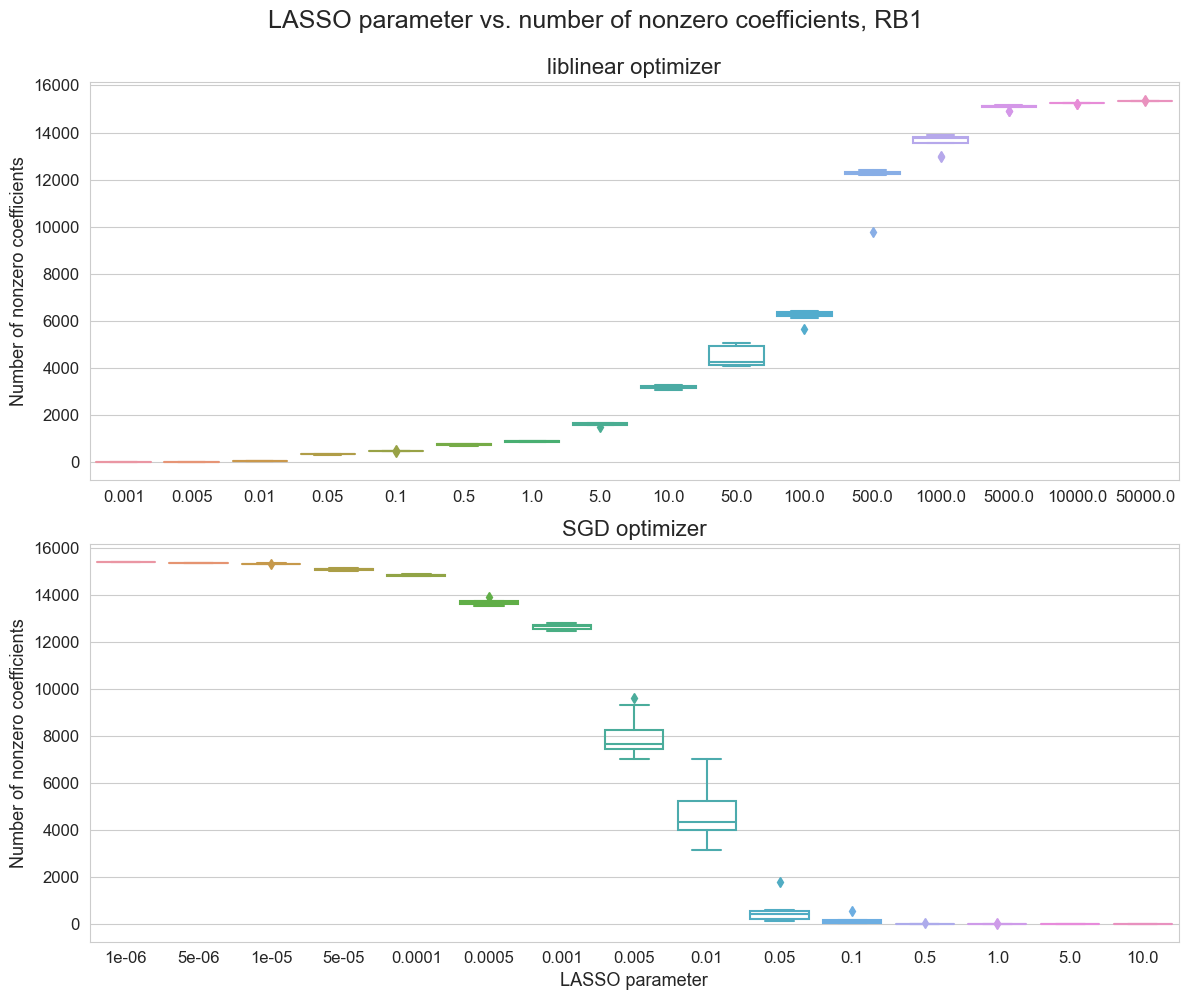

In [5]:
sns.set({'figure.figsize': (12, 10)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(2, 1)

sns.boxplot(
    data=ll_nz_coefs_df.sort_values(by=['lasso_param']),
    x='lasso_param', y='nz_coefs', ax=axarr[0]
)
axarr[0].set_title('liblinear optimizer', size=16)
axarr[0].set_xlabel('')
axarr[0].set_ylabel('Number of nonzero coefficients', size=13)
axarr[0].tick_params(axis='both', labelsize=12)

sns.boxplot(
    data=sgd_nz_coefs_df.sort_values(by=['lasso_param']),
    x='lasso_param', y='nz_coefs', ax=axarr[1]
)
axarr[1].set_title('SGD optimizer', size=16)
axarr[1].set_xlabel('LASSO parameter', size=13)
axarr[1].set_ylabel('Number of nonzero coefficients', size=13)
axarr[1].tick_params(axis='both', labelsize=12)

# color the boxplot lines/edges rather than the box fill
# this makes it easier to discern colors at the extremes; i.e. very many or few nonzero coefs
# https://stackoverflow.com/a/72333641
def color_boxes(ax):
    box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
    num_patches = len(box_patches)
    lines_per_boxplot = len(ax.lines) // num_patches
    for i, patch in enumerate(box_patches):
        # set the linecolor on the patch to the facecolor, and set the facecolor to None
        col = patch.get_facecolor()
        patch.set_edgecolor(col)
        patch.set_facecolor('None')

        # each box has associated Line2D objects (to make the whiskers, fliers, etc.)
        # loop over them here, and use the same color as above
        for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
            line.set_color(col)
            line.set_mfc(col)  # facecolor of fliers
            line.set_mec(col)  # edgecolor of fliers
            
color_boxes(axarr[0])
color_boxes(axarr[1])

plt.suptitle(
    f'LASSO parameter vs. number of nonzero coefficients, {plot_gene}',
    size=18, y=0.995
)

plt.tight_layout()

### Get performance information for each lasso penalty

In [6]:
ll_perf_df = au.load_prediction_results_lasso_range(ll_results_dir,
                                                    'stratified',
                                                    gene=plot_gene)
ll_perf_df = (
    ll_perf_df[ll_perf_df.gene == plot_gene]
    .drop(columns=['holdout_cancer_type', 'experiment'])
    .copy()
)
ll_perf_df.head()

,auroc,aupr,gene,signal,seed,data_type,fold,lasso_param
0,1.00000,1.00000,RB1,signal,1,train,0,50000.0
1,0.66967,0.21378,RB1,signal,1,test,0,50000.0
2,0.79050,0.27633,RB1,signal,1,cv,0,50000.0
3,1.00000,1.00000,RB1,signal,1,train,1,50000.0
4,0.77723,0.25220,RB1,signal,1,test,1,50000.0


In [7]:
sgd_perf_df = au.load_prediction_results_lasso_range(sgd_results_dir,
                                                     'stratified',
                                                     gene=plot_gene)
sgd_perf_df = (
    sgd_perf_df[sgd_perf_df.gene == plot_gene]
    .drop(columns=['holdout_cancer_type', 'experiment'])
    .copy()
)
sgd_perf_df.head()

,auroc,aupr,gene,signal,seed,data_type,fold,lasso_param
0,1.00000,1.00000,RB1,signal,1,train,0,1e-05
1,0.75102,0.40206,RB1,signal,1,test,0,1e-05
2,0.79402,0.39066,RB1,signal,1,cv,0,1e-05
3,1.00000,1.00000,RB1,signal,1,train,1,1e-05
4,0.77809,0.33326,RB1,signal,1,test,1,1e-05


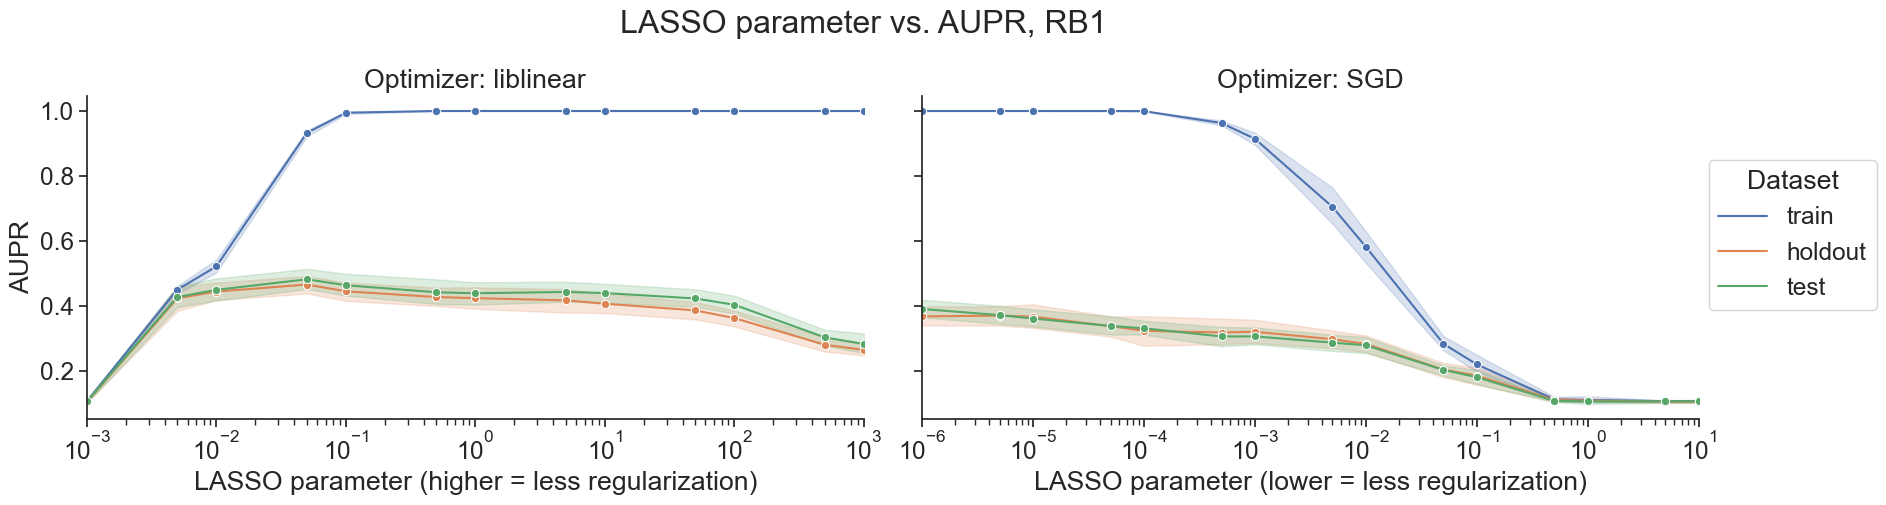

In [8]:
sns.set_style('ticks')

ll_plot_df = (
    ll_perf_df[(ll_perf_df.signal == 'signal')]
      .sort_values(by=['lasso_param'])
      .reset_index(drop=True)
)
ll_plot_df.lasso_param = ll_plot_df.lasso_param.astype(float)

sgd_plot_df = (
    sgd_perf_df[(sgd_perf_df.signal == 'signal')]
      .sort_values(by=['lasso_param'])
      .reset_index(drop=True)
)
sgd_plot_df.lasso_param = sgd_plot_df.lasso_param.astype(float)

ll_plot_df['optimizer'] = 'liblinear'
sgd_plot_df['optimizer'] = 'SGD'

plot_df = pd.concat((ll_plot_df, sgd_plot_df))

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.relplot(
        data=plot_df,
        x='lasso_param', y=metric, hue='data_type',
        hue_order=['train', 'cv', 'test'],
        marker='o', kind='line', col='optimizer',
        col_wrap=2, height=5, aspect=1.6,
        facet_kws={'sharex': False}
    )
    g.set(xscale='log', xlim=(min(plot_df.lasso_param), max(plot_df.lasso_param)))
    g.axes[0].set_xlabel('LASSO parameter (higher = less regularization)')
    g.axes[0].set_xlim((10e-4, 10e2))
    g.axes[1].set_xlabel('LASSO parameter (lower = less regularization)')
    g.axes[1].set_xlim((10e-7, 10))
    g.set_ylabels(f'{metric.upper()}')
    sns.move_legend(g, "center", bbox_to_anchor=[1.035, 0.55], frameon=True)
    g._legend.set_title('Dataset')
    new_labels = ['train', 'holdout', 'test']
    for t, l in zip(g._legend.texts, new_labels):
        t.set_text(l)
    g.set_titles('Optimizer: {col_name}')
     
    plt.suptitle(f'LASSO parameter vs. {metric.upper()}, {plot_gene}', y=1.0)

plt.tight_layout()

In [9]:
ll_nz_coefs_df['optimizer'] = 'liblinear'
sgd_nz_coefs_df['optimizer'] = 'SGD'

nz_coefs_df = pd.concat((ll_nz_coefs_df, sgd_nz_coefs_df))
nz_coefs_df.head()

,gene,signal,lasso_param,seed,fold,nz_coefs,optimizer
0,RB1,signal,10.00,42,0,3105,liblinear
1,RB1,signal,10.00,42,1,3167,liblinear
2,RB1,signal,10.00,42,2,3217,liblinear
3,RB1,signal,10.00,42,3,3067,liblinear
4,RB1,signal,0.05,1,0,310,liblinear


In [10]:
perf_coefs_df = (plot_df
    .merge(nz_coefs_df,
           left_on=['gene', 'optimizer', 'lasso_param', 'seed', 'fold'],
           right_on=['gene', 'optimizer', 'lasso_param', 'seed', 'fold'])
)

print(perf_coefs_df.shape)
perf_coefs_df.head()

(744, 11)


,auroc,aupr,gene,signal_x,seed,data_type,fold,lasso_param,optimizer,signal_y,nz_coefs
0,0.5,0.103970,RB1,signal,42,cv,3,0.001,liblinear,signal,0
1,0.5,0.108800,RB1,signal,42,train,3,0.001,liblinear,signal,0
2,0.5,0.101230,RB1,signal,42,test,3,0.001,liblinear,signal,0
3,0.5,0.095463,RB1,signal,1,cv,3,0.001,liblinear,signal,0
4,0.5,0.108800,RB1,signal,1,train,3,0.001,liblinear,signal,0


,quantile,value
0,0.1,0.0
1,0.2,15.0
2,0.3,348.0
3,0.4,887.0
4,0.5,4097.0
5,0.6,7816.0
6,0.7,13620.0
7,0.8,15075.0
8,0.9,15321.0


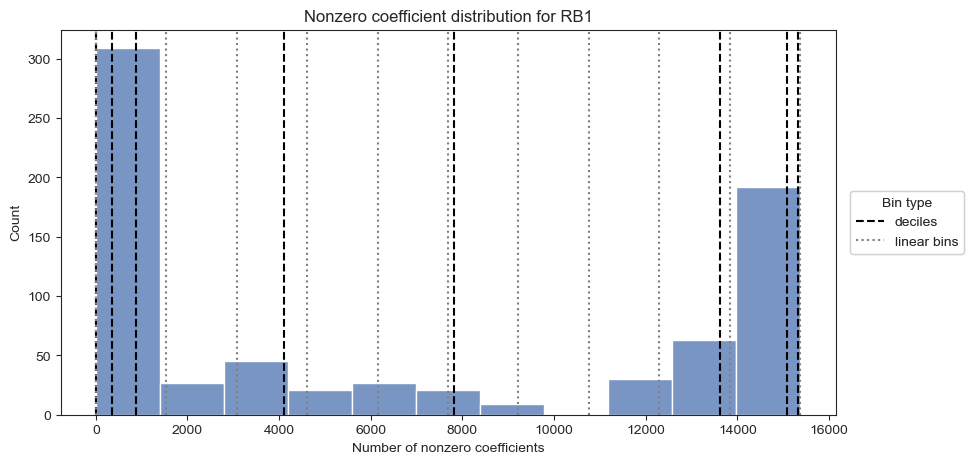

In [11]:
sns.set({'figure.figsize': (10, 5)})
sns.set_style('ticks')
sns.histplot(perf_coefs_df.nz_coefs)
plt.title(f'Nonzero coefficient distribution for {plot_gene}')
plt.xlabel('Number of nonzero coefficients')

linear_bins_df = []
quantiles_df = []

ax = plt.gca()
for q in np.linspace(0.1, 0.9, 9):
    quantiles_df.append([q, perf_coefs_df.nz_coefs.quantile(q)])
    ax.axvline(x=perf_coefs_df.nz_coefs.quantile(q),
                      color='black', linestyle='--')
    
for b in np.linspace(0, perf_coefs_df.nz_coefs.max(), 11):
    ax.axvline(x=b, color='grey', linestyle=':')
    
# create custom legend for bin boundary lines
legend_handles = [
    Line2D([0], [0], color='black', linestyle='--'),
    Line2D([0], [0], color='grey', linestyle=':'),
]
legend_labels = ['deciles', 'linear bins']
l = ax.legend(legend_handles, legend_labels, title='Bin type',
              loc='lower left', bbox_to_anchor=(1.01, 0.4))
ax.add_artist(l)
    
quantiles_df = pd.DataFrame(quantiles_df, columns=['quantile', 'value'])
quantiles_df

In [12]:
# TODO: figure out 0 quantile general solution
perf_coefs_df['nz_linear_bin'] = pd.cut(
    perf_coefs_df.nz_coefs,
    bins=np.linspace(0, perf_coefs_df.nz_coefs.max(), 11),
    labels=[f'{q}' for q in range(1, 11)],
    include_lowest=True
)

print(perf_coefs_df.nz_linear_bin.unique().sort_values())
perf_coefs_df.head()

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
Categories (10, object): ['1' < '2' < '3' < '4' ... '7' < '8' < '9' < '10']


,auroc,aupr,gene,signal_x,seed,data_type,fold,lasso_param,optimizer,signal_y,nz_coefs,nz_linear_bin
0,0.5,0.103970,RB1,signal,42,cv,3,0.001,liblinear,signal,0,1
1,0.5,0.108800,RB1,signal,42,train,3,0.001,liblinear,signal,0,1
2,0.5,0.101230,RB1,signal,42,test,3,0.001,liblinear,signal,0,1
3,0.5,0.095463,RB1,signal,1,cv,3,0.001,liblinear,signal,0,1
4,0.5,0.108800,RB1,signal,1,train,3,0.001,liblinear,signal,0,1


In [13]:
# sometimes there are enough classifiers with O nonzero coefficients, or the
# max number of coefficients, such that they are covered by a whole decile
# in that case, we drop the duplicate deciles and combine them into one (so we'll
# have e.g. 9 bins instead of 10 deciles)
range_bounds = (0.0, float(perf_coefs_df.nz_coefs.max()))
print(range_bounds)

num_quantiles = quantiles_df[~quantiles_df.value.isin(range_bounds)].shape[0]
print(num_quantiles, 'unique quantiles')

perf_coefs_df['nz_quantile'] = pd.qcut(
    perf_coefs_df.nz_coefs,
    q=np.linspace(0, 1, 11),
    labels=[f'{q}' for q in range(1, num_quantiles+2)],
    duplicates='drop'
)

print(perf_coefs_df.nz_quantile.unique().sort_values())
perf_coefs_df.head()

(0.0, 15374.0)
8 unique quantiles
['1', '2', '3', '4', '5', '6', '7', '8', '9']
Categories (9, object): ['1' < '2' < '3' < '4' ... '6' < '7' < '8' < '9']


,auroc,aupr,gene,signal_x,seed,data_type,fold,lasso_param,optimizer,signal_y,nz_coefs,nz_linear_bin,nz_quantile
0,0.5,0.103970,RB1,signal,42,cv,3,0.001,liblinear,signal,0,1,1
1,0.5,0.108800,RB1,signal,42,train,3,0.001,liblinear,signal,0,1,1
2,0.5,0.101230,RB1,signal,42,test,3,0.001,liblinear,signal,0,1,1
3,0.5,0.095463,RB1,signal,1,cv,3,0.001,liblinear,signal,0,1,1
4,0.5,0.108800,RB1,signal,1,train,3,0.001,liblinear,signal,0,1,1


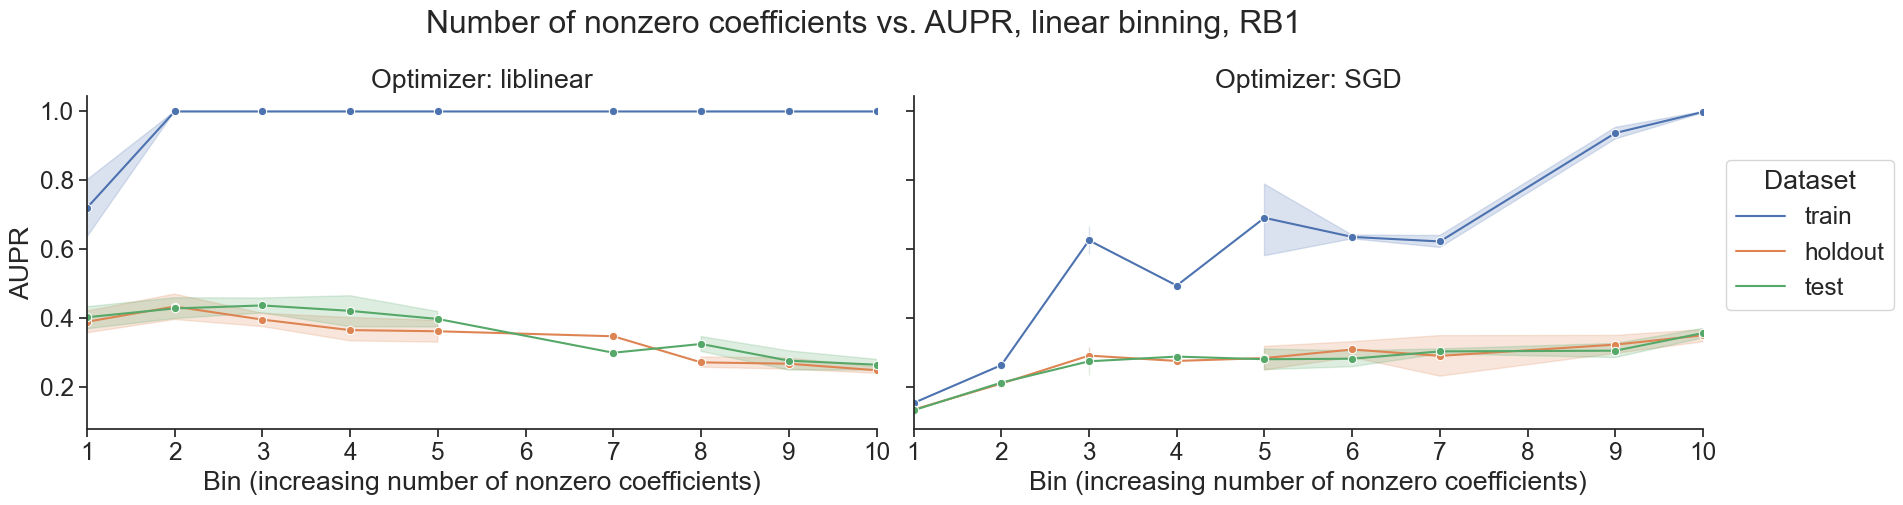

In [14]:
sns.set_style('ticks')

ll_plot_df = (
    perf_coefs_df[(perf_coefs_df.optimizer == 'liblinear')]
      .sort_values(by=['nz_linear_bin'])
      .reset_index(drop=True)
)

sgd_plot_df = (
    perf_coefs_df[(perf_coefs_df.optimizer == 'sgd')]
      .sort_values(by=['nz_linear_bin'])
      .reset_index(drop=True)
)

plot_df = pd.concat((ll_plot_df, sgd_plot_df))

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.relplot(
        data=perf_coefs_df,
        x='nz_linear_bin', y=metric, hue='data_type',
        hue_order=['train', 'cv', 'test'],
        marker='o', kind='line', col='optimizer',
        col_wrap=2, height=5, aspect=1.6,
        facet_kws={'sharex': False}
    )
    g.axes[0].set_xlabel('Bin (increasing number of nonzero coefficients)')
    g.axes[0].set_xlim((0, perf_coefs_df.nz_linear_bin.max()))
    g.axes[1].set_xlabel('Bin (increasing number of nonzero coefficients)')
    g.axes[1].set_xlim((0, perf_coefs_df.nz_linear_bin.max()))
    g.set_ylabels(f'{metric.upper()}')
    sns.move_legend(g, "center", bbox_to_anchor=[1.045, 0.55], frameon=True)
    g._legend.set_title('Dataset')
    new_labels = ['train', 'holdout', 'test']
    for t, l in zip(g._legend.texts, new_labels):
        t.set_text(l)
    g.set_titles('Optimizer: {col_name}')
     
    plt.suptitle(
        f'Number of nonzero coefficients vs. {metric.upper()}, linear binning, {plot_gene}',
        y=1.0
    )

plt.tight_layout()

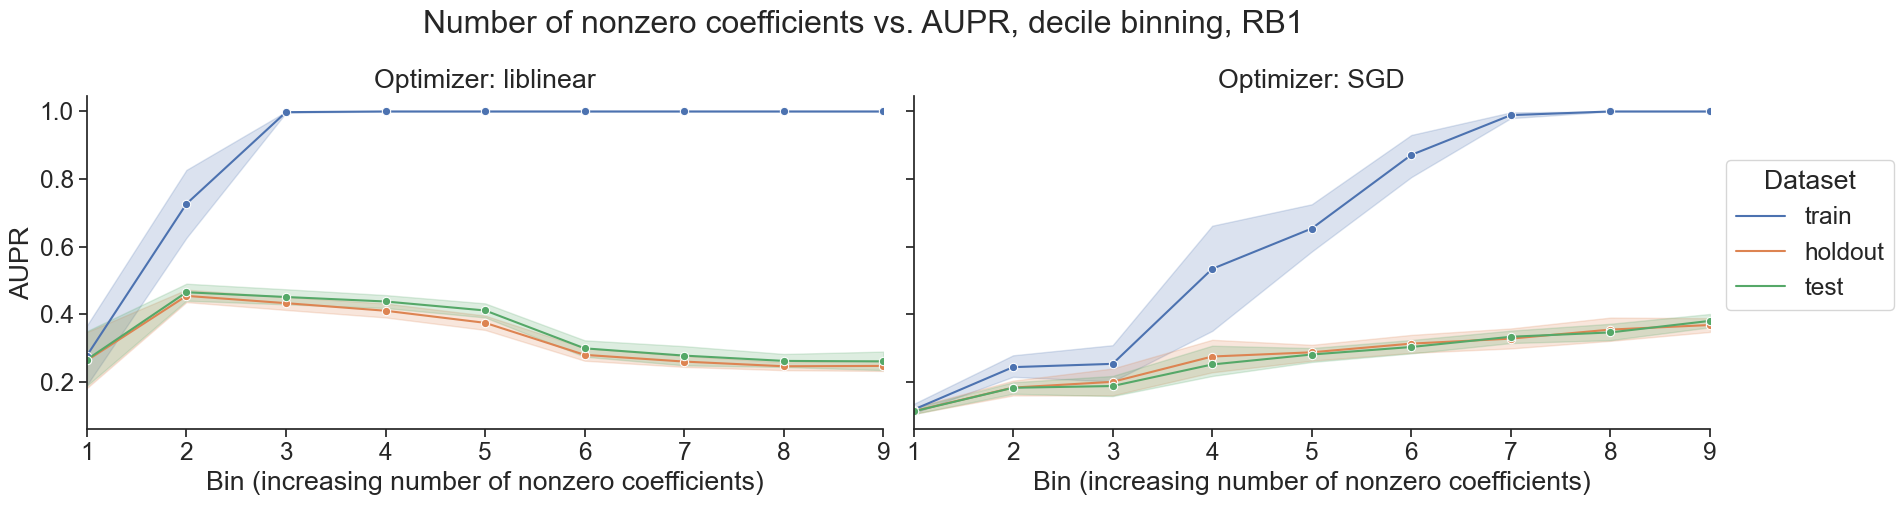

In [15]:
sns.set_style('ticks')

ll_plot_df = (
    perf_coefs_df[(perf_coefs_df.optimizer == 'liblinear')]
      .sort_values(by=['nz_quantile'])
      .reset_index(drop=True)
)

sgd_plot_df = (
    perf_coefs_df[(perf_coefs_df.optimizer == 'sgd')]
      .sort_values(by=['nz_quantile'])
      .reset_index(drop=True)
)

plot_df = pd.concat((ll_plot_df, sgd_plot_df))

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.relplot(
        data=perf_coefs_df,
        x='nz_quantile', y=metric, hue='data_type',
        hue_order=['train', 'cv', 'test'],
        marker='o', kind='line', col='optimizer',
        col_wrap=2, height=5, aspect=1.6,
        facet_kws={'sharex': False}
    )
    g.axes[0].set_xlabel('Bin (increasing number of nonzero coefficients)')
    g.axes[0].set_xlim((0, perf_coefs_df.nz_quantile.max()))
    g.axes[1].set_xlabel('Bin (increasing number of nonzero coefficients)')
    g.axes[1].set_xlim((0, perf_coefs_df.nz_quantile.max()))
    g.set_ylabels(f'{metric.upper()}')
    sns.move_legend(g, "center", bbox_to_anchor=[1.045, 0.55], frameon=True)
    g._legend.set_title('Dataset')
    new_labels = ['train', 'holdout', 'test']
    for t, l in zip(g._legend.texts, new_labels):
        t.set_text(l)
    g.set_titles('Optimizer: {col_name}')
     
    plt.suptitle(
        f'Number of nonzero coefficients vs. {metric.upper()}, decile binning, {plot_gene}',
        y=1.0
    )

plt.tight_layout()